In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
import xgboost as xgb
import seaborn as sns
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE
import time
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier,TPOTRegressor
from sklearn import preprocessing

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [3]:
df = pd.read_excel('GTEx_pancreas_liver_images_liverfat_pancreasfat_seq.xlsx', index_col=-5)

cols_liver = [
#     'Sex',
#     'Age.Bracket',
#     'Hardy.Scale',
#     'Pathology.Categories_liver',
#     'Pathology.Notes_liver',
    'Fat,Percentage_liver',
       ]
df_liver = df[cols_liver]
df_liver = df_liver[~df_liver.index.duplicated()]
df_liver

,"Fat,Percentage_liver"
SAMPID_liver,
GTEX-11EQ9-0526-SM-5A5JZ,27.468310
GTEX-11GSP-0626-SM-5986T,26.623697
GTEX-11TT1-1726-SM-5EQLJ,21.957421
GTEX-12WSD-1426-SM-5GCN9,26.766371
GTEX-12WSG-0626-SM-5FQTQ,38.365642
...,...
GTEX-ZPU1-0826-SM-7DHMN,19.230492
GTEX-ZTPG-1426-SM-51MT3,31.414259
GTEX-ZVP2-0626-SM-51MSO,61.633606


In [4]:
df_gen = pd.read_csv('countMatrixLiver.tsv', sep = '\t').T
df_gen = df_gen[~df_gen.index.duplicated()]
df_gen

,0,1,2,3,4,5,6,7,8,9,...,56190,56191,56192,56193,56194,56195,56196,56197,56198,56199
GTEX-11EQ9-0526-SM-5A5JZ,1,39,0,1,0,1,0,1,1,4,...,1956309,3,3,5,400649,142490,61,843511,2,4
GTEX-11GSP-0626-SM-5986T,3,56,0,0,0,0,5,4,2,0,...,3745154,4,1,5,522722,120446,69,2104116,3,4
GTEX-11TT1-1726-SM-5EQLJ,0,21,0,0,0,0,0,3,2,4,...,603892,3,1,1,151128,51065,22,268144,0,0
GTEX-12WSD-1426-SM-5GCN9,1,175,0,3,1,0,2,12,0,0,...,2285755,3,1,1,368379,84548,9,1401420,0,2
GTEX-12WSG-0626-SM-5FQTQ,0,31,0,0,0,1,2,1,0,2,...,1318708,0,3,1,159445,39628,9,638466,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZPU1-0826-SM-57WG2,0,74,0,0,2,1,1,2,3,0,...,1054957,2,1,5,237891,72686,84,492830,1,4
GTEX-ZTPG-1426-SM-51MT3,2,124,0,0,0,2,1,3,3,7,...,1209858,1,1,0,203279,65907,9,588044,1,2
GTEX-ZVP2-0626-SM-51MSO,5,81,0,1,0,0,2,2,3,1,...,1718143,4,6,3,498280,251674,123,791002,1,0
GTEX-ZYT6-0626-SM-5E45V,1,40,0,0,0,0,3,4,0,4,...,2835899,2,1,3,225573,60138,11,1210022,1,2


In [5]:
df_liver = df_liver.loc[df_gen.index,:]

In [6]:
result = pd.concat([df_gen, df_liver], axis=1)
result

,0,1,2,3,4,5,6,7,8,9,...,56191,56192,56193,56194,56195,56196,56197,56198,56199,"Fat,Percentage_liver"
GTEX-11EQ9-0526-SM-5A5JZ,1,39,0,1,0,1,0,1,1,4,...,3,3,5,400649,142490,61,843511,2,4,27.468310
GTEX-11GSP-0626-SM-5986T,3,56,0,0,0,0,5,4,2,0,...,4,1,5,522722,120446,69,2104116,3,4,26.623697
GTEX-11TT1-1726-SM-5EQLJ,0,21,0,0,0,0,0,3,2,4,...,3,1,1,151128,51065,22,268144,0,0,21.957421
GTEX-12WSD-1426-SM-5GCN9,1,175,0,3,1,0,2,12,0,0,...,3,1,1,368379,84548,9,1401420,0,2,26.766371
GTEX-12WSG-0626-SM-5FQTQ,0,31,0,0,0,1,2,1,0,2,...,0,3,1,159445,39628,9,638466,2,0,38.365642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZPU1-0826-SM-57WG2,0,74,0,0,2,1,1,2,3,0,...,2,1,5,237891,72686,84,492830,1,4,19.230492
GTEX-ZTPG-1426-SM-51MT3,2,124,0,0,0,2,1,3,3,7,...,1,1,0,203279,65907,9,588044,1,2,31.414259
GTEX-ZVP2-0626-SM-51MSO,5,81,0,1,0,0,2,2,3,1,...,4,6,3,498280,251674,123,791002,1,0,61.633606
GTEX-ZYT6-0626-SM-5E45V,1,40,0,0,0,0,3,4,0,4,...,2,1,3,225573,60138,11,1210022,1,2,31.571405


In [7]:
x = result.drop('Fat,Percentage_liver', axis=1).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

X

,0,1,2,3,4,5,6,7,8,9,...,56190,56191,56192,56193,56194,56195,56196,56197,56198,56199
0,0.2,0.068966,0.0,0.083333,0.000000,0.066667,0.000000,0.045455,0.0625,0.210526,...,0.286967,0.017647,0.036145,0.625,0.246672,0.235489,0.172619,0.256964,0.068966,0.011765
1,0.6,0.122257,0.0,0.000000,0.000000,0.000000,0.192308,0.181818,0.1250,0.000000,...,0.570494,0.023529,0.012048,0.625,0.333303,0.193714,0.196429,0.663428,0.103448,0.011765
2,0.0,0.012539,0.0,0.000000,0.000000,0.000000,0.000000,0.136364,0.1250,0.210526,...,0.072613,0.017647,0.012048,0.125,0.069596,0.062231,0.056548,0.071445,0.000000,0.000000
3,0.2,0.495298,0.0,0.250000,0.111111,0.000000,0.076923,0.545455,0.0000,0.000000,...,0.339183,0.017647,0.012048,0.125,0.223771,0.125684,0.017857,0.436854,0.000000,0.005882
4,0.0,0.043887,0.0,0.000000,0.000000,0.066667,0.076923,0.045455,0.0000,0.105263,...,0.185909,0.000000,0.036145,0.125,0.075498,0.040557,0.017857,0.190850,0.068966,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.178683,0.0,0.000000,0.222222,0.066667,0.038462,0.090909,0.1875,0.000000,...,0.144105,0.011765,0.012048,0.625,0.131169,0.103205,0.241071,0.143892,0.034483,0.011765
82,0.4,0.335423,0.0,0.000000,0.000000,0.133333,0.038462,0.136364,0.1875,0.368421,...,0.168657,0.005882,0.012048,0.000,0.106606,0.090358,0.017857,0.174592,0.034483,0.005882
83,1.0,0.200627,0.0,0.083333,0.000000,0.000000,0.076923,0.090909,0.1875,0.052632,...,0.249218,0.023529,0.072289,0.375,0.315958,0.442403,0.357143,0.240033,0.034483,0.000000
84,0.2,0.072100,0.0,0.000000,0.000000,0.000000,0.115385,0.181818,0.0000,0.210526,...,0.426379,0.011765,0.012048,0.375,0.122427,0.079425,0.023810,0.375140,0.034483,0.005882


In [8]:
# X.drop([col for col, val in X.sum().iteritems() if val < 33.05], axis=1, inplace=True)
# X.shape[1]

In [9]:
# X = result.drop('Fat.Percentage_liver', axis=1).values
# y = result['Fat,Percentage_liver'].values
y = pd.qcut(result['Fat,Percentage_liver'],4, labels=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [10]:
# pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
#                                     random_state=42,n_jobs=-1, verbosity=3)
# opt = pipeline_optimizer.fit(X_train, y_train)
# opt.fitted_pipeline_

In [11]:
# y_pred = opt.fitted_pipeline_.predict(X_test)

In [12]:
# opt.export('pipeline.py')

In [13]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(X_train,y_train)

In [14]:
# xg_reg = xgb.XGBClassifier()
# xg_reg.fit(X_train,y_train)
# y_pred = xg_reg.predict(X_test)

In [15]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.6000000000000001, min_samples_leaf=20, min_samples_split=10, n_estimators=100)),
    RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.05, min_samples_leaf=13, min_samples_split=15, n_estimators=100)
)

set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train,y_train)
y_pred = exported_pipeline.predict(X_test)

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('F1:  {}'.format(f1_score(y_test.values, y_pred, average='macro')))
print('acc:  {}'.format(accuracy_score(y_test.values, y_pred)))

F1:  0.08433734939759037
acc:  0.2028985507246377


In [17]:
xg_reg = xgb.XGBClassifier()
xg_reg.fit(X_train,y_train)
y_pred1 = xg_reg.predict(X_test)

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('F1:  {}'.format(f1_score(y_test.values, y_pred1, average='macro')))
print('acc:  {}'.format(accuracy_score(y_test.values, y_pred1)))

F1:  0.22797169811320755
acc:  0.2753623188405797


[Text(0, 0, 'OOB Xgboost'),
 Text(0, 0, 'TPOTed RandomForest'),
 Text(0, 0, 'Siamese Neural Network')]

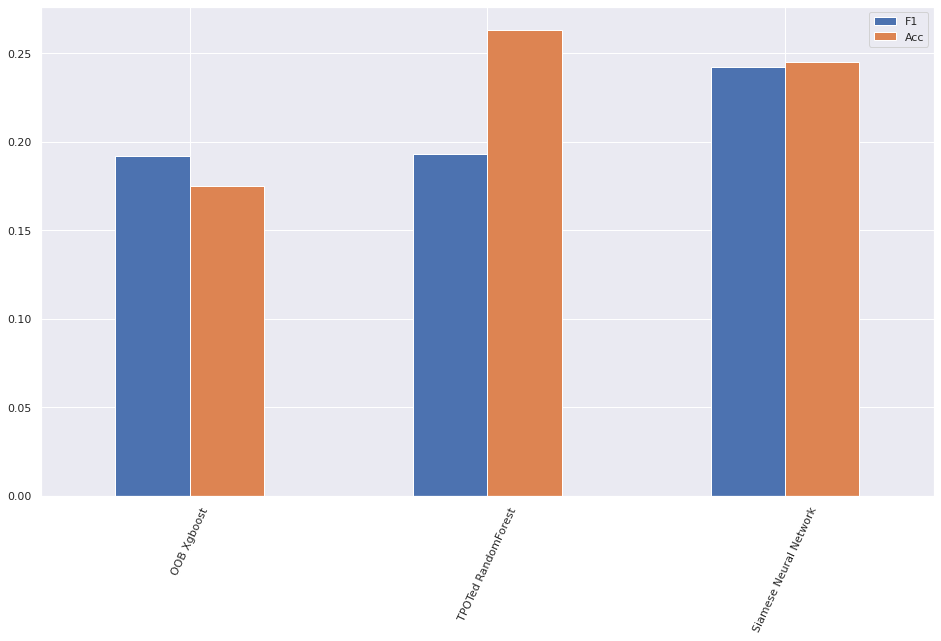

In [19]:
dct = {'OOB Xgboost':[0.192,0.175],
        'TPOTed RandomForest': [0.193,0.2631],
        'Siamese Neural Network':[0.242,0.245]
}
ls = ['a','b','c']
sns.set()
plot_df = pd.DataFrame.from_dict(dct, orient='index', columns = ['F1', 'Acc'])
ax = plot_df.plot(kind = 'bar', figsize = (16,9))
ax.set_xticklabels(plot_df.index, rotation=65)
# plt.xlabel(ls,rotation=75)
# plt.set_xticklabels(df.index,rotation=75)



In [20]:
ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

NameError: name 'tips' is not defined

In [ ]:
# time_start = time.time()
# tsne = TSNE(n_components=900, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(X.values)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# # Create correlation matrix
# corr_matrix = X.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# result1 = X.drop(result[to_drop], axis=1)
# result1

In [ ]:
# pca = FastICA(n_components=900)
# pca_result = pca.fit_transform(X)
# # print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# pca_result.shape

In [ ]:
# pipeline_optimizer = TPOTRegressor(generations=5, population_size=20, cv=5,
#                                     random_state=42,n_jobs=-1, verbosity=3)
# opt = pipeline_optimizer.fit(X_train, y_train)
# opt.fitted_pipeline_

In [ ]:
# xg_reg = xgb.XGBRegressor()
# rez = xg_reg.fit(X_train,y_train)
# y_pred = xg_reg.predict(X_test)

In [ ]:
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score

# print('F1:  {}'.format(f1_score(y_test, y_pred, average='macro')))
# print('acc:  {}'.format(accuracy_score(y_test, y_pred)))

# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# print('r2:  {}'.format(r2_score(y_test, y_pred)))
# print('MAE:  {}'.format(mean_squared_error(y_test, y_pred)))

In [ ]:
# # df0 = df_liver['Fat.Percentage_liver']
# # df0 = pd.cut(df_liver['Fat.Percentage_liver'],bins=4, labels=False)
# df0 = pd.qcut(df_liver['Fat.Percentage_liver'],4, labels=False)
# df1 = pd.get_dummies(df_liver[['Sex','Age.Bracket']])
# df2 = df_liver['Hardy.Scale'].str.get_dummies(sep='-').add_prefix('Hardy.Scale_')
# df3 = df_liver['Pathology.Categories_liver'].str.get_dummies(sep=',').add_prefix('Pathology.Categories_liver_')
# # df4 = df_liver['Pathology.Notes_liver'].str.get_dummies(sep=',').add_prefix('Pathology.Notes_liver_')
# result = pd.concat([df1,df2,df3,df0], axis=1, sort=False)
# result.head()

In [ ]:
# pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
#                                     random_state=42,n_jobs=-1, verbosity=3)
# opt = pipeline_optimizer.fit(X_train, y_train)

In [ ]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [ ]:
# from sklearn.metrics import plot_confusion_matrix
# # Plot non-normalized confusion matrix
# titles_options = [("Confusion matrix, without normalization", None),
#                   ("Normalized confusion matrix", 'true')]
# for title, normalize in titles_options:
#     disp = plot_confusion_matrix(rez, X_test, y_test,
#                                  cmap=plt.cm.Blues,
#                                  normalize=normalize)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

In [ ]:
# df_liver['Fat.Percentage_liver'].sort_values().plot()
# df_liver['Fat.Percentage_liver'].hist(bins=100)

In [ ]:
# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(result.drop('Fat.Percentage_liver', axis=1).values)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# result['tsne-2d-one'] = tsne_results[:,0]
# result['tsne-2d-two'] = tsne_results[:,1]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one",
#     y="tsne-2d-two",
#     hue="Fat.Percentage_liver",
#     palette=sns.color_palette("hls", 4),
#     data=result,
#     legend="full",
#     alpha=0.8
# )

In [ ]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(result.drop('Fat.Percentage_liver', axis=1).values)
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
# result['pca-one'] = pca_result[:,0]
# result['pca-two'] = pca_result[:,1] 
# # result['pca-three'] = pca_result[:,2]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="pca-one",
#     y="pca-two",
#     hue="Fat.Percentage_liver",
#     palette=sns.color_palette("hls", 4),
#     data=result,
#     legend="full",
#     alpha=0.3
# )

In [ ]:
# # Create correlation matrix
# corr_matrix = result.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# result1 = result.drop(result[to_drop], axis=1)
# result1

In [ ]:
# # Correlation Matrix Heatmap
# f, ax = plt.subplots(figsize=(16, 9))
# corr = result.corr()
# hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
#                  linewidths=.05)
# # # f.subplots_adjust(top=0.93)
# # t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

In [ ]:
# df_test = pd.read_excel('GTEx_pancreas_liver_images_liverfat_pancreasfat_seq.xlsx', index_col=0)
# test_cols = [
#     'Sex',
#     'Age.Bracket',
#     'Hardy.Scale',
#     'Pathology.Categories_pancreas',
#     'Pathology.Categories_liver',
#     'Fat,Percentage_liver',
#     'Fat,Percentage_pancreas'
#        ]
# df_test = df_test[test_cols]

In [ ]:
# categorical_features = [
#     'Sex',
#     'Age.Bracket',
#     'Hardy.Scale',
# ]

# fig, ax = plt.subplots(1, len(categorical_features), figsize=(16,9))
# for i, categorical_feature in enumerate(df[categorical_features]):
#     df[categorical_feature].value_counts().plot(kind = "bar", ax=ax[i]).set_title(categorical_feature)
#     plt.tight_layout()
# fig.show()

In [ ]:
# categorical_features = [
#     'Pathology.Categories_pancreas',
#     'Pathology.Categories_liver'
# ]

# fig, ax = plt.subplots(1, len(categorical_features), figsize=(16,9))
# for i, categorical_feature in enumerate(df[categorical_features]):
#     df[categorical_feature].value_counts().plot(kind = "bar", ax=ax[i]).set_title(categorical_feature)
#     plt.tight_layout()
# fig.show()

In [ ]:
# df[['Fat.Percentage_liver']].sort_values('Fat.Percentage_liver').plot(kind='bar', figsize=(16,9))

In [ ]:
# df[['Fat.Percentage_pancreas']].sort_values('Fat.Percentage_pancreas').plot(kind='bar', figsize=(16,9))

In [ ]:
# cols1 = [
#     'Sex',
#     'Age.Bracket',
#     'Hardy.Scale',
#     'Pathology.Categories_pancreas',
#     'Pathology.Categories_liver',
#        ]
# X_train = df1[cols1]
# y_train = df1['Fat.Percentage_liver']
# X_test = df_test[cols1]
# y_test = df_test['Fat,Percentage_liver']

In [ ]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(X_train,y_train)

In [ ]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)
# clf.predict(X_test)